Constantes: tamanho do Mock e instância do Faker


In [1]:
from faker import Faker
USER_COUNT = 118758
fake = Faker()

# Funções usadas ao longo do Notebook

Gerar dia válido dentro de um determinado mês. Prioriza primeiros dias.

In [2]:
import numpy as np
import calendar
from scipy.stats import expon

def generate_days(
        month: tuple[int, int],
        size: int,
        start_day: int=1
    ) -> np.ndarray | None:
    _, last_day = calendar.monthrange(*month)
    if start_day == last_day:
        return np.full((size,), start_day)
    elif start_day > last_day:
        return None
    available_days = np.arange(start=start_day, stop=last_day + 1)
    weights = np.copy(available_days)
    weights = weights / np.sum(weights)
    weights = expon.pdf(weights)
    weights = weights / np.sum(weights)
    return np.random.choice(available_days, size=size, p=weights)

# Dados de Usuário


Iremos gerar um DataFrame Pandas para conter informações de usuário, assim como o endereço do mesmo.


In [3]:
import pandas as pd

users = pd.DataFrame({
    'id': [fake.uuid4() for _ in range(USER_COUNT)],
    'created_at': None,
    'birthday': None,
    'city': None,
    'state': None,
    'country': None
})
display(users)

,id,created_at,birthday,city,state,country
0,44b27ee6-4d52-42c6-9c01-b0f30f538c8b,None,None,None,None,None
1,036c79ec-50c1-4661-a789-4a9ebf60cffc,None,None,None,None,None
2,af1bee4d-e18e-4f66-9278-7128887fae8a,None,None,None,None,None
3,79b4be67-26a9-4fdf-9ce2-f8832c4cdb0c,None,None,None,None,None
4,60443d34-81fc-43ef-b99b-8338fa1aacad,None,None,None,None,None
...,...,...,...,...,...,...
118753,41b6dc8e-a8e9-480f-8b60-207d81cf5e3d,None,None,None,None,None
118754,4dc9c777-7353-4511-81c4-5c69ef269970,None,None,None,None,None
118755,59f36e4c-dc46-4ca9-948f-ba88b5af5aa8,None,None,None,None,None
118756,7543caad-77a9-4aa9-b651-58d74a288b91,None,None,None,None,None


Gerando _created_at_ (omitindo _updated_at_ pois ele não aparece em nenhum lugar do relatório)


Utilizando distribuição ponderada, priorizando os meses 2, 3 e 4.


Primeiro dia: 2023-01-01 00:00:00
Último dia: 2023-06-30 00:00:00


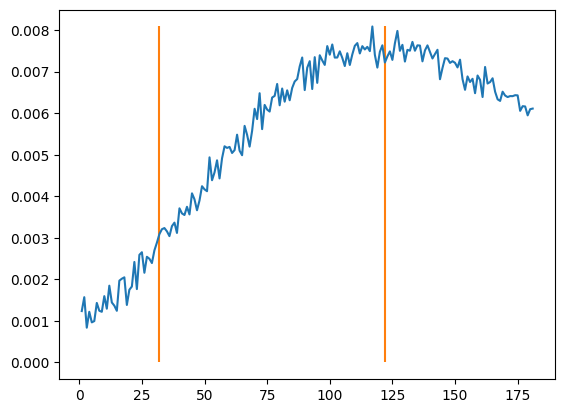

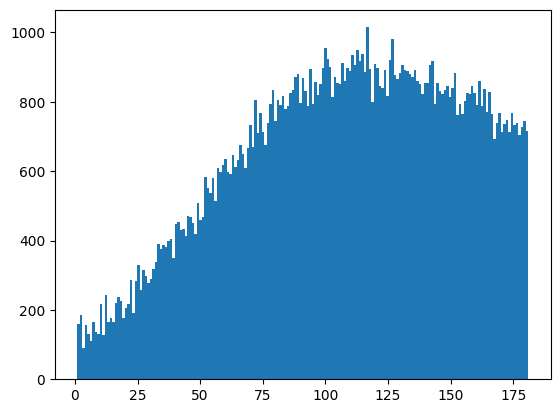

In [4]:
from scipy.stats import skewnorm
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

# Dia 1 -> 01/01/2023
# Dia 2 -> 02/01/2023
# ...
# Dia 181 -> 30/06/2023
# Priorizar meses 2, 3 e 4:
# Mês 1: do dia 1 ao 31
# Mês 2: do dia 32 ao 59
# Mês 3: do dia 60 ao 90
# Mês 4: do dia 91 ao 120
# Mês 5: do dia 121 ao 151
# Mês 6: dia 152 ao 181
# Média: dia 76
# Desvio padrão: 30
# Skewness: 0.5
first_day = 1
last_day = 181
print(f'Primeiro dia: {datetime(2023, 1, 1) + timedelta(days=first_day - 1)}')
print(f'Último dia: {datetime(2023, 1, 1) + timedelta(days=last_day - 1)}')
available_days = np.arange(first_day, last_day + 1)
lin_range = np.linspace(0, 1, last_day - first_day + 1)
weights = skewnorm.pdf(x=lin_range, a=3.0, loc=0.3, scale=0.75)
# Noise
weights = np.abs(weights + np.random.normal(loc=0, scale=0.025, size=last_day - first_day + 1))
weights = weights / np.sum(weights)
plt.gca().vlines(np.array([32, 122]), ymin=0, ymax=np.max(weights), color='C1')
plt.plot(np.arange(first_day, last_day + 1), weights)
plt.show()

days = np.random.choice(available_days, size=USER_COUNT, p=weights)
plt.hist(days, bins=last_day - first_day + 1)
plt.show()

Horas não são aleatórias: priorizar horários de pico


In [7]:
import numpy as np
from scipy.stats import skewnorm


def gen_random_minutes(size):
    minutes = skewnorm.rvs(a=-0.5, loc=960, scale=240, size=size)
    while True:
        minutes = np.round(minutes, 0).astype(int)
        minutes_outside_interval = np.argwhere(
            (minutes < 0) | (minutes >= 1440)).flatten()
        if (minutes_outside_interval.size == 0):
            break
        minutes[minutes_outside_interval] = skewnorm.rvs(
            a=-0.5, loc=960, scale=240, size=len(minutes_outside_interval))
    return minutes


minutes = gen_random_minutes(USER_COUNT)
hours = minutes // 60
minutes = minutes % 60

Adicionando created_at


In [8]:
from datetime import datetime, timedelta
import numpy as np

def _created_at_gen(day, hour, minute):
    return (datetime(
        2023,
        1,
        1,
        hour,
        minute,
        np.random.randint(0, 60)) + timedelta(days=int(day - 1))).isoformat()
created_at_gen = np.vectorize(_created_at_gen)
created_at = created_at_gen(days, hours, minutes)
users['created_at'] = created_at

Gerando datas de nascimento


Ano será escolhido através de uma distribuição que prioriza fim dos anos 90 e anos 2000


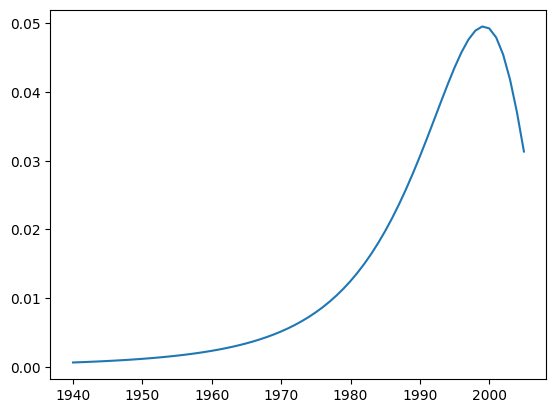

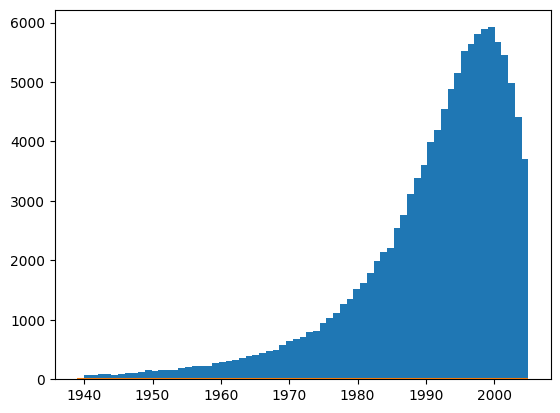

In [9]:
from matplotlib import pyplot as plt
from scipy.stats import alpha

available_years = np.arange(2005, 1939, -1)
lins = np.linspace(0, 1, len(available_years))
weights = alpha.pdf(lins, 3.6, loc=-0.4, scale=2)
weights = weights / np.sum(weights)
plt.plot(available_years, weights)
plt.show()
plt.gca().vlines([1990, 1995, 2000, 2005], ymin=0, ymax=np.max(weights), color='C1')
plt.gca().hlines(0, xmin=1939, xmax=2005, color='C1')
random_years = np.random.choice(available_years, size=USER_COUNT, p=weights)
plt.hist(random_years, bins=available_years.size)
plt.show()

Mês e dia são completamente randômicos, utiliza distribuição uniforme


In [10]:
random_dates_with_year = np.empty((USER_COUNT,), dtype=object)
for i in range(USER_COUNT):
    year = random_years[i]
    lower_bound = datetime(year, 1, 1)
    upper_bound = datetime(year, 12, 31)
    random_date = fake.date_between(
        start_date=lower_bound, end_date=upper_bound).strftime('%Y-%m-%d')
    random_dates_with_year[i] = random_date
users['birthday'] = random_dates_with_year

Ordenando DataFrame de forma que created_at seja crescente


In [11]:
users = users.sort_values(by='created_at')
users = users.reset_index(drop=True)
display(users)

,id,created_at,birthday,city,state,country
0,c5b7bb3a-048f-4805-bed8-42807ff4f924,2023-01-01T04:05:31,1966-05-12,None,None,None
1,82c85f22-64bc-457a-85f0-1fdb6813d1f6,2023-01-01T05:33:54,1998-08-04,None,None,None
2,de55eb18-e764-4513-bee5-f52861994ad1,2023-01-01T06:11:29,1986-04-26,None,None,None
3,92239043-c387-442c-b564-c9225ee2eb5c,2023-01-01T06:30:02,1984-05-23,None,None,None
4,6fbf3ec4-0d1c-4677-815c-16ae6ac3bdce,2023-01-01T06:33:08,1998-09-06,None,None,None
...,...,...,...,...,...,...
118753,eaba6d52-0025-4261-86cd-167b0d6b23d7,2023-06-30T22:49:06,1994-01-10,None,None,None
118754,263ef208-f20e-41ba-a33f-e3e3c21b56da,2023-06-30T22:53:56,2002-08-23,None,None,None
118755,55d34fdd-3a96-47ec-b1b6-1d7b240cfd12,2023-06-30T22:54:50,1988-04-22,None,None,None
118756,4b4cc06a-a723-4fad-b3e9-df5ad3c76cbb,2023-06-30T22:56:19,1998-11-08,None,None,None


Obtendo índices para cada mês

In [12]:
users['c_at_month'] = users['created_at'].str.slice(start=5, stop=7).apply(lambda str: int(str))
month_intervals = []
for i in range(1, 7):
    idxs = users.index[users['c_at_month'] == i].tolist()
    start_idx = idxs[0]
    end_idx = idxs[-1]
    month_intervals.append((start_idx, end_idx))

# Endereços


Queremos mudar a distribuição de endereços com base na data do onboarding. Portanto, é interessante antes criar uma função que recebe alguns parâmetros, como:

- Importância da população para decidir a cidade
- Presença de cidades fora do Brasil?
- etc


## Cidades do Brasil

Utilizando .csv de municipios contidos [aqui](http://blog.mds.gov.br/redesuas/wp-content/uploads/2018/06/Lista_Munic%C3%ADpios_com_IBGE_Brasil_Versao_CSV.csv)


In [13]:
# Renomeie o CSV
municipios = pd.read_csv('municipios.csv', sep=';')
# Ignorando duas colunas
municipios = municipios.drop(columns=[
    'ConcatUF+Mun',
    'Unnamed: 9']).sort_values(by=['População 2010'], ascending=False)
# Ignorando munícipios sem informação de população
municipios = municipios.dropna(subset=['População 2010'])
municipios = municipios.reset_index(drop=True)
display(municipios.head(5))
# Transformando Presidente Prudente em uma cidade com 2M de habitantes
# Só pelo lulz
municipios.loc[
    municipios['Município'] == 'Presidente Prudente',
    'População 2010'
  ] = 2000000
display(municipios[municipios['Município'] == 'Presidente Prudente'])

,IBGE,IBGE7,UF,Município,Região,População 2010,Porte,Capital
0,355030,3550308,SP,São Paulo,Região Sudeste,11253503.0,Metrópole,Capital
1,330455,3304557,RJ,Rio de Janeiro,Região Sudeste,6320446.0,Metrópole,Capital
2,292740,2927408,BA,Salvador,Região Nordeste,2675656.0,Metrópole,Capital
3,530010,5300108,DF,Brasília,Região Centro-Oeste,2570160.0,Metrópole,Capital
4,230440,2304400,CE,Fortaleza,Região Nordeste,2452185.0,Metrópole,Capital


,IBGE,IBGE7,UF,Município,Região,População 2010,Porte,Capital
125,354140,3541406,SP,Presidente Prudente,Região Sudeste,2000000.0,Grande,NaN


## Cidades fora do Brasil

Utilizando csv que pode ser encontrado [aqui](https://simplemaps.com/static/data/world-cities/basic/simplemaps_worldcities_basicv1.76.zip)


Países da América Latina


In [14]:
latin_america_countries = [
    'Argentina',
    'Bolivia',
    'Chile',
    'Colombia',
    'Ecuador',
    'Paraguay',
    'Peru',
    'Uruguay'
]

In [15]:
world_cities = pd.read_csv('worldcities.csv')
# Ignorando cidades sem dados populacionais
world_cities = world_cities.dropna(subset=['population'])
# Incluindo apenas cidades da América Latina (exclui Brasil)
world_cities = world_cities[world_cities['country'].isin(latin_america_countries)]
# Excluindo cidades com população menor que 500 mil habitantes
world_cities = world_cities[world_cities['population'] >= 500000]
world_cities = world_cities.reset_index(drop=True)
display(world_cities.head(5))

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Buenos Aires,Buenos Aires,-34.5997,-58.3819,Argentina,AR,ARG,"Buenos Aires, Ciudad Autónoma de",primary,16710000.0,1032717330
1,Lima,Lima,-12.0600,-77.0375,Peru,PE,PER,Lima,primary,10320000.0,1604728603
2,Bogotá,Bogota,4.7111,-74.0722,Colombia,CO,COL,Bogotá,primary,7968095.0,1170483426
3,Santiago,Santiago,-33.4372,-70.6506,Chile,CL,CHL,Región Metropolitana,primary,7171000.0,1152554349
4,Timbío,Timbio,2.3445,-76.6839,Colombia,CO,COL,Cauca,minor,4444444.0,1170815311


Finalmente, preparando a função


In [16]:
def generate_random_cities(size, population_importance=1.6, non_brazilian_percent=0.0):
    brazilian_percent = 1.0 - non_brazilian_percent
    brazilian_size = int(size * brazilian_percent)
    non_brazilian_size = size - brazilian_size
    cities = pd.DataFrame(columns=['city', 'state', 'country'])
    # Cidades brasileiras
    brazilian_cities = pd.DataFrame(columns=['city', 'state', 'country'])
    brazilian_population_power = np.power(
        municipios['População 2010'], population_importance)
    brazilian_population_weights = brazilian_population_power / \
        np.sum(brazilian_population_power)
    brazilian_cities_idx = np.random.choice(
        municipios.index, p=brazilian_population_weights, size=brazilian_size)
    brazilian_cities['city'] = municipios.loc[brazilian_cities_idx,
                                              'Município'].values
    brazilian_cities['state'] = municipios.loc[brazilian_cities_idx, 'UF'].values
    brazilian_cities['country'] = 'Brazil'
    # Cidades não brasileiras
    non_brazilian_cities = pd.DataFrame(columns=['city', 'state', 'country'])
    non_brazilian_population_power = np.power(
        world_cities['population'], population_importance)
    non_brazilian_population_weights = non_brazilian_population_power / \
        np.sum(non_brazilian_population_power)
    non_brazilian_cities_idx = np.random.choice(
        world_cities.index, p=non_brazilian_population_weights, size=non_brazilian_size)
    non_brazilian_cities['city'] = world_cities.loc[non_brazilian_cities_idx, 'city'].values
    non_brazilian_cities['state'] = ''
    non_brazilian_cities['country'] = world_cities.loc[non_brazilian_cities_idx, 'country'].values
    # Concatenando
    cities = pd.concat([brazilian_cities, non_brazilian_cities])
    cities = cities.reset_index(drop=True)
    return cities

Primeiros 2 meses: focar em capitais do Brasil


In [17]:
start_idx = month_intervals[0][0]
end_idx = month_intervals[1][1]
count = end_idx - start_idx
cities = generate_random_cities(count, population_importance=2.5)
users.loc[users.index[start_idx: end_idx], [
    'city', 'state', 'country']] = cities.values

2 próximos meses: cidades brasileiras com menor população


In [18]:
start_idx = month_intervals[2][0]
end_idx = month_intervals[3][1]
count = end_idx - start_idx
cities = generate_random_cities(count, population_importance=1.5)
users.loc[users.index[start_idx: end_idx], [
    'city', 'state', 'country']] = cities.values

2 últimos meses: cidades no exterior


In [19]:
start_idx = month_intervals[4][0]
end_idx = month_intervals[5][1]
count = end_idx - start_idx
cities = generate_random_cities(
    count, population_importance=1.0, non_brazilian_percent=0.05)
users.loc[users.index[start_idx: end_idx], [
    'city', 'state', 'country']] = cities.values

Resultado final


In [20]:
display(users['country'].value_counts())
display(users['state'].value_counts())
display(users['city'].value_counts())

country
Brazil       116251
Colombia        758
Argentina       672
Peru            427
Chile           238
Bolivia         224
Ecuador         124
Uruguay          52
Paraguay          9
Name: count, dtype: int64

state
SP    43981
RJ    14990
MG     8343
BA     6492
PR     4419
CE     4325
RS     4203
PE     3701
PA     3117
GO     2563
       2504
MA     2462
DF     2378
SC     2235
AM     1955
PB     1387
ES     1378
AL     1293
RN     1254
MT     1145
PI     1113
MS     1021
SE      742
RO      571
TO      449
AP      295
AC      277
RR      162
Name: count, dtype: int64

city
São Paulo            29610
Rio de Janeiro       10555
Salvador              2673
Brasília              2378
Fortaleza             2275
                     ...  
Caraúbas do Piauí        1
Anita Garibaldi          1
Divisa Nova              1
Motuca                   1
Áurea                    1
Name: count, Length: 4618, dtype: int64

# Salvando dados de usuário em CSV


In [21]:
display(users)

,id,created_at,birthday,city,state,country,c_at_month
0,c5b7bb3a-048f-4805-bed8-42807ff4f924,2023-01-01T04:05:31,1966-05-12,Fortaleza,CE,Brazil,1
1,82c85f22-64bc-457a-85f0-1fdb6813d1f6,2023-01-01T05:33:54,1998-08-04,São Paulo,SP,Brazil,1
2,de55eb18-e764-4513-bee5-f52861994ad1,2023-01-01T06:11:29,1986-04-26,São Paulo,SP,Brazil,1
3,92239043-c387-442c-b564-c9225ee2eb5c,2023-01-01T06:30:02,1984-05-23,São Paulo,SP,Brazil,1
4,6fbf3ec4-0d1c-4677-815c-16ae6ac3bdce,2023-01-01T06:33:08,1998-09-06,São Paulo,SP,Brazil,1
...,...,...,...,...,...,...,...
118753,eaba6d52-0025-4261-86cd-167b0d6b23d7,2023-06-30T22:49:06,1994-01-10,Buenos Aires,,Argentina,6
118754,263ef208-f20e-41ba-a33f-e3e3c21b56da,2023-06-30T22:53:56,2002-08-23,Santiago,,Chile,6
118755,55d34fdd-3a96-47ec-b1b6-1d7b240cfd12,2023-06-30T22:54:50,1988-04-22,Montevideo,,Uruguay,6
118756,4b4cc06a-a723-4fad-b3e9-df5ad3c76cbb,2023-06-30T22:56:19,1998-11-08,Lima,,Peru,6


In [22]:
from datetime import datetime

def age_from_birthday(birthday_str):
    birthday = datetime.fromisoformat(birthday_str)
    difference = datetime.now() - birthday
    age = difference.days // 365
    return age


users['age'] = users['birthday'].apply(age_from_birthday)
display(users)
users.drop('c_at_month', axis=1).to_csv('users.csv', index=False)

,id,created_at,birthday,city,state,country,c_at_month,age
0,c5b7bb3a-048f-4805-bed8-42807ff4f924,2023-01-01T04:05:31,1966-05-12,Fortaleza,CE,Brazil,1,57
1,82c85f22-64bc-457a-85f0-1fdb6813d1f6,2023-01-01T05:33:54,1998-08-04,São Paulo,SP,Brazil,1,24
2,de55eb18-e764-4513-bee5-f52861994ad1,2023-01-01T06:11:29,1986-04-26,São Paulo,SP,Brazil,1,37
3,92239043-c387-442c-b564-c9225ee2eb5c,2023-01-01T06:30:02,1984-05-23,São Paulo,SP,Brazil,1,39
4,6fbf3ec4-0d1c-4677-815c-16ae6ac3bdce,2023-01-01T06:33:08,1998-09-06,São Paulo,SP,Brazil,1,24
...,...,...,...,...,...,...,...,...
118753,eaba6d52-0025-4261-86cd-167b0d6b23d7,2023-06-30T22:49:06,1994-01-10,Buenos Aires,,Argentina,6,29
118754,263ef208-f20e-41ba-a33f-e3e3c21b56da,2023-06-30T22:53:56,2002-08-23,Santiago,,Chile,6,20
118755,55d34fdd-3a96-47ec-b1b6-1d7b240cfd12,2023-06-30T22:54:50,1988-04-22,Montevideo,,Uruguay,6,35
118756,4b4cc06a-a723-4fad-b3e9-df5ad3c76cbb,2023-06-30T22:56:19,1998-11-08,Lima,,Peru,6,24


# Transferências


## Função que gera transferências com determinada distribuição de valores e horas


In [23]:
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import calendar


def generate_transfers(
        user_ids,
        transfer_quantity,
        loc=50,
        scale=25,
        num_outliers=0
    ):
    transfers = pd.DataFrame(
        columns=[
            'id_from',
            'id_to',
            'hour',
            'minute',
            'scheduled_date',
            'value',
            'status'
        ]
    )
    ids_from, ids_to = user_ids
    total_size = transfer_quantity
    values = np.random.normal(
        loc=loc,
        scale=scale,
        size=total_size - num_outliers
    )
    values = np.append(values, np.random.normal(
            loc=3000,
            scale=1000,
            size=num_outliers
        )
    )
    values = np.abs(values)
    values = np.round(values, 2)
    status = np.random.choice(
        ['FAILED', 'DONE', 'SCHEDULED'],
        p=[0.001, 0.6, 0.399], size=total_size)
    # Chose random ids
    transfers_ids_from = np.random.choice(ids_from, size=total_size)
    transfers_ids_to = np.random.choice(ids_to, size=total_size)
    transfers['id_from'] = transfers_ids_from
    transfers['id_to'] = transfers_ids_to
    transfers['value'] = values
    transfers['status'] = status
    # Horário das transferências
    minutes = gen_random_minutes(total_size)
    hours = minutes // 60
    minutes = minutes % 60
    transfers['hour'] = hours
    transfers['minute'] = minutes
    return transfers


def decide_transfers_dates(transfers: pd.DataFrame):
    users_created_at = users[['id', 'created_at']]
    transfer_with_user_info = pd\
        .merge(
            transfers,
            users_created_at,
            left_on='id_from',
            right_on='id',
            how='inner')\
        .drop('id', axis=1)
    transfer_with_user_info = pd\
        .merge(
            transfer_with_user_info,
            users_created_at,
            left_on='id_to',
            right_on='id',
            how='inner')\
        .drop('id', axis=1)
    transfer_with_user_info['lower_bound'] = transfer_with_user_info\
        .apply(
            lambda row: max(
                row['created_at_x'],
                row['created_at_y']
            ),
            axis=1
    )
    transfer_with_user_info = transfer_with_user_info\
        .drop(
            ['created_at_x', 'created_at_y'],
            axis=1
        )
    def gen_month_day(hour, minute, lower_bound):
        lower_bound = datetime.fromisoformat(lower_bound)
        month = np.random.randint(lower_bound.month, 8)
        _, last_day = calendar.monthrange(2023, month)
        if month == 7:
            day = 1
        else:
            if month > lower_bound.month:
                start_day = 1
            else:
                start_day = lower_bound.day
            date = datetime(2023, month, start_day, int(hour), int(minute))
            if (date <= lower_bound):
                start_day += 1
                if start_day > last_day:
                    month += 1
                    start_day = 1
            day = generate_days((2023, month), 1, start_day=start_day)[0]
        date = datetime(2023, month, day, hour, minute)
        if (date > lower_bound):
            return (day, month)
    gen_month_day_vectorized = np.vectorize(gen_month_day)
    temp = np.array([
        transfer_with_user_info['hour'],
        transfer_with_user_info['minute'],
        transfer_with_user_info['lower_bound']
    ])
    day, month = gen_month_day_vectorized(*temp)
    temp_t = temp.transpose()
    temp = np.array([
        month,
        day,
        temp_t[:, 0],
        temp_t[:, 1]
    ])
    def gen_date_time(month, day, hour, minute):
        return datetime(
            2023,
            month,
            day,
            hour,
            minute,
            np.random.randint(0, 60)).isoformat()
    gen_date_time_vectorized = np.vectorize(gen_date_time)
    date_times = gen_date_time_vectorized(*temp)
    new_transfers = transfers.copy()
    new_transfers.drop(['hour', 'minute'], axis=1, inplace=True)
    new_transfers['time'] = date_times
    return new_transfers

Usuários na faixa de 18-25: valores mais baixos


In [24]:
user_subpopulation = users['age'].between(18, 25)
subpopulation_size = user_subpopulation.count()
active_sample_size = int(0.6 * subpopulation_size)
active_users_ids = np.random.choice(users[user_subpopulation]['id'], size=active_sample_size)
transfers_amount = 5 * active_sample_size
transfers_18_25 = generate_transfers(
    (active_users_ids, users['id']), transfers_amount, loc=80, scale=50, num_outliers=int(transfers_amount * 0.01))

In [25]:
transfers_18_25 = decide_transfers_dates(transfers_18_25)
display(transfers_18_25)

,id_from,id_to,scheduled_date,value,status,time
0,a5eca78e-f89d-4775-b3ed-4d051020617b,6f6c9fba-41bc-4366-82cd-8510b1feb163,NaN,57.47,DONE,2023-06-30T15:07:24
1,7eff739c-691b-424a-b75d-a94a6a1aa164,8c77eff5-283d-41e8-81e8-82bd022cb097,NaN,128.00,DONE,2023-06-27T20:12:27
2,945727b9-f5c8-4018-9189-03f38400645f,2212acc9-1b14-49b1-9878-29e6cd61e2ab,NaN,87.78,DONE,2023-06-30T16:57:45
3,7e7d1e35-f58f-44ca-add5-c117054e9bb7,bcb09129-f7c9-4550-aa3f-dcb7082b07dc,NaN,62.68,DONE,2023-07-01T20:05:33
4,aebb4be9-56b0-41d4-abc0-43b87aefc022,61475034-50f5-481b-9987-522d9119fbc1,NaN,1.73,SCHEDULED,2023-06-29T13:40:09
...,...,...,...,...,...,...
356265,f1c353e8-7f2d-422a-a470-d4dc3efa3044,af014cb5-6a1d-4626-9bc3-ee71d44c11f8,NaN,2993.48,SCHEDULED,2023-07-01T12:46:20
356266,efe0820d-962c-43cf-9be7-4c4d9104893b,482688ab-a277-4eeb-a7fc-3a4129cf7111,NaN,914.27,SCHEDULED,2023-05-29T13:02:16
356267,8ba34cb8-3ea5-4013-9e33-31adfb8aa4f9,bef4d236-3872-4603-9137-f273965f62f6,NaN,3773.88,DONE,2023-07-01T15:53:35
356268,f5c290e9-0dd2-404d-b76d-4cf480b801a4,666bafe1-3f70-4153-8203-21cdbe4b75e7,NaN,3047.52,SCHEDULED,2023-03-11T16:53:27


In [26]:
from datetime import datetime

def generate_scheduled_date(status, time):
    if status == 'SCHEDULED':
        return fake.date_between(
            datetime.fromisoformat(time),
            datetime(2023, 7, 31))
    else:
        return None

generate_scheduled_date_vectorized = np.vectorize(generate_scheduled_date)
input_matrix = np.array([
    transfers_18_25['status'],
    transfers_18_25['time']
])
scheduled = generate_scheduled_date_vectorized(*input_matrix)
transfers_18_25['scheduled_date'] = scheduled
display(transfers_18_25)

,id_from,id_to,scheduled_date,value,status,time
0,a5eca78e-f89d-4775-b3ed-4d051020617b,6f6c9fba-41bc-4366-82cd-8510b1feb163,None,57.47,DONE,2023-06-30T15:07:24
1,7eff739c-691b-424a-b75d-a94a6a1aa164,8c77eff5-283d-41e8-81e8-82bd022cb097,None,128.00,DONE,2023-06-27T20:12:27
2,945727b9-f5c8-4018-9189-03f38400645f,2212acc9-1b14-49b1-9878-29e6cd61e2ab,None,87.78,DONE,2023-06-30T16:57:45
3,7e7d1e35-f58f-44ca-add5-c117054e9bb7,bcb09129-f7c9-4550-aa3f-dcb7082b07dc,None,62.68,DONE,2023-07-01T20:05:33
4,aebb4be9-56b0-41d4-abc0-43b87aefc022,61475034-50f5-481b-9987-522d9119fbc1,2023-07-19,1.73,SCHEDULED,2023-06-29T13:40:09
...,...,...,...,...,...,...
356265,f1c353e8-7f2d-422a-a470-d4dc3efa3044,af014cb5-6a1d-4626-9bc3-ee71d44c11f8,2023-07-25,2993.48,SCHEDULED,2023-07-01T12:46:20
356266,efe0820d-962c-43cf-9be7-4c4d9104893b,482688ab-a277-4eeb-a7fc-3a4129cf7111,2023-05-30,914.27,SCHEDULED,2023-05-29T13:02:16
356267,8ba34cb8-3ea5-4013-9e33-31adfb8aa4f9,bef4d236-3872-4603-9137-f273965f62f6,None,3773.88,DONE,2023-07-01T15:53:35
356268,f5c290e9-0dd2-404d-b76d-4cf480b801a4,666bafe1-3f70-4153-8203-21cdbe4b75e7,2023-07-12,3047.52,SCHEDULED,2023-03-11T16:53:27


In [27]:
transfers = pd.concat([transfers_18_25], axis=0)

In [28]:
display(transfers)

,id_from,id_to,scheduled_date,value,status,time
0,a5eca78e-f89d-4775-b3ed-4d051020617b,6f6c9fba-41bc-4366-82cd-8510b1feb163,None,57.47,DONE,2023-06-30T15:07:24
1,7eff739c-691b-424a-b75d-a94a6a1aa164,8c77eff5-283d-41e8-81e8-82bd022cb097,None,128.00,DONE,2023-06-27T20:12:27
2,945727b9-f5c8-4018-9189-03f38400645f,2212acc9-1b14-49b1-9878-29e6cd61e2ab,None,87.78,DONE,2023-06-30T16:57:45
3,7e7d1e35-f58f-44ca-add5-c117054e9bb7,bcb09129-f7c9-4550-aa3f-dcb7082b07dc,None,62.68,DONE,2023-07-01T20:05:33
4,aebb4be9-56b0-41d4-abc0-43b87aefc022,61475034-50f5-481b-9987-522d9119fbc1,2023-07-19,1.73,SCHEDULED,2023-06-29T13:40:09
...,...,...,...,...,...,...
356265,f1c353e8-7f2d-422a-a470-d4dc3efa3044,af014cb5-6a1d-4626-9bc3-ee71d44c11f8,2023-07-25,2993.48,SCHEDULED,2023-07-01T12:46:20
356266,efe0820d-962c-43cf-9be7-4c4d9104893b,482688ab-a277-4eeb-a7fc-3a4129cf7111,2023-05-30,914.27,SCHEDULED,2023-05-29T13:02:16
356267,8ba34cb8-3ea5-4013-9e33-31adfb8aa4f9,bef4d236-3872-4603-9137-f273965f62f6,None,3773.88,DONE,2023-07-01T15:53:35
356268,f5c290e9-0dd2-404d-b76d-4cf480b801a4,666bafe1-3f70-4153-8203-21cdbe4b75e7,2023-07-12,3047.52,SCHEDULED,2023-03-11T16:53:27


Usuários na faixa de 26-60: valores mais altos


In [29]:
user_subpopulation = users['age'].between(26, 60)
subpopulation_size = user_subpopulation.count()
active_sample_size = int(0.6 * subpopulation_size)
active_users_ids = np.random.choice(users[user_subpopulation]['id'], size=active_sample_size)
transfers_amount = 5 * active_sample_size
transfers_26_60 = generate_transfers(
    (active_users_ids, users['id']), transfers_amount, loc=500, scale=200, num_outliers=int(transfers_amount * 0.01))
transfers_26_60 = decide_transfers_dates(transfers_26_60)
generate_scheduled_date_vectorized = np.vectorize(generate_scheduled_date)
input_matrix = np.array([
    transfers_26_60['status'],
    transfers_26_60['time']
])
scheduled = generate_scheduled_date_vectorized(*input_matrix)
transfers_26_60['scheduled_date'] = scheduled

In [30]:
transfers = pd.concat([transfers, transfers_26_60], axis=0)
display(transfers)

,id_from,id_to,scheduled_date,value,status,time
0,a5eca78e-f89d-4775-b3ed-4d051020617b,6f6c9fba-41bc-4366-82cd-8510b1feb163,None,57.47,DONE,2023-06-30T15:07:24
1,7eff739c-691b-424a-b75d-a94a6a1aa164,8c77eff5-283d-41e8-81e8-82bd022cb097,None,128.00,DONE,2023-06-27T20:12:27
2,945727b9-f5c8-4018-9189-03f38400645f,2212acc9-1b14-49b1-9878-29e6cd61e2ab,None,87.78,DONE,2023-06-30T16:57:45
3,7e7d1e35-f58f-44ca-add5-c117054e9bb7,bcb09129-f7c9-4550-aa3f-dcb7082b07dc,None,62.68,DONE,2023-07-01T20:05:33
4,aebb4be9-56b0-41d4-abc0-43b87aefc022,61475034-50f5-481b-9987-522d9119fbc1,2023-07-19,1.73,SCHEDULED,2023-06-29T13:40:09
...,...,...,...,...,...,...
356265,9db5ec56-0d4b-48f0-b3a1-d963ee078ed0,3fdf9e9b-c3b3-4296-9e91-9127696ec1ce,None,3208.66,DONE,2023-06-04T14:07:37
356266,2a3e0da8-8962-40bf-a7d0-c2ca9ee5472f,02f7ce61-cafb-4fd8-8266-4e5db5e71a1b,2023-06-21,3409.71,SCHEDULED,2023-05-19T12:18:39
356267,d2484391-b619-4e22-8f66-af7e04bb6e6e,8db4505e-ba72-4698-8fa8-739a4cd32aee,2023-07-25,2682.95,SCHEDULED,2023-07-01T10:04:26
356268,3244ac3f-f3dc-4a54-9479-4acfc34de07b,7ff91d73-315d-4502-99dc-b59011a6d9a0,2023-06-24,4578.31,SCHEDULED,2023-06-19T16:19:12


Usuários na faixa de 60+: valores mais baixos


In [31]:
user_subpopulation = users['age'].between(61, 999)
subpopulation_size = user_subpopulation.count()
active_sample_size = int(0.25 * subpopulation_size)
active_users_ids = np.random.choice(users[user_subpopulation]['id'], size=active_sample_size)
transfers_amount = 3 * active_sample_size
transfers_61_plus = generate_transfers(
    (active_users_ids, users['id']), transfers_amount, loc=200, scale=80, num_outliers=int(transfers_amount * 0.001))
transfers_61_plus = decide_transfers_dates(transfers_61_plus)
generate_scheduled_date_vectorized = np.vectorize(generate_scheduled_date)
input_matrix = np.array([
    transfers_61_plus['status'],
    transfers_61_plus['time']
])
scheduled = generate_scheduled_date_vectorized(*input_matrix)
transfers_61_plus['scheduled_date'] = scheduled

Formato do DataFrame

In [32]:
display(transfers)

,id_from,id_to,scheduled_date,value,status,time
0,a5eca78e-f89d-4775-b3ed-4d051020617b,6f6c9fba-41bc-4366-82cd-8510b1feb163,None,57.47,DONE,2023-06-30T15:07:24
1,7eff739c-691b-424a-b75d-a94a6a1aa164,8c77eff5-283d-41e8-81e8-82bd022cb097,None,128.00,DONE,2023-06-27T20:12:27
2,945727b9-f5c8-4018-9189-03f38400645f,2212acc9-1b14-49b1-9878-29e6cd61e2ab,None,87.78,DONE,2023-06-30T16:57:45
3,7e7d1e35-f58f-44ca-add5-c117054e9bb7,bcb09129-f7c9-4550-aa3f-dcb7082b07dc,None,62.68,DONE,2023-07-01T20:05:33
4,aebb4be9-56b0-41d4-abc0-43b87aefc022,61475034-50f5-481b-9987-522d9119fbc1,2023-07-19,1.73,SCHEDULED,2023-06-29T13:40:09
...,...,...,...,...,...,...
356265,9db5ec56-0d4b-48f0-b3a1-d963ee078ed0,3fdf9e9b-c3b3-4296-9e91-9127696ec1ce,None,3208.66,DONE,2023-06-04T14:07:37
356266,2a3e0da8-8962-40bf-a7d0-c2ca9ee5472f,02f7ce61-cafb-4fd8-8266-4e5db5e71a1b,2023-06-21,3409.71,SCHEDULED,2023-05-19T12:18:39
356267,d2484391-b619-4e22-8f66-af7e04bb6e6e,8db4505e-ba72-4698-8fa8-739a4cd32aee,2023-07-25,2682.95,SCHEDULED,2023-07-01T10:04:26
356268,3244ac3f-f3dc-4a54-9479-4acfc34de07b,7ff91d73-315d-4502-99dc-b59011a6d9a0,2023-06-24,4578.31,SCHEDULED,2023-06-19T16:19:12


In [33]:
# Ordenando por `time`
transfers = transfers.sort_values(by='time')
display(transfers)

,id_from,id_to,scheduled_date,value,status,time
316096,63205a12-58db-4fd7-a10d-2b4096e9afed,bf3bda88-cad8-4047-8514-7a467f41359d,None,142.46,DONE,2023-01-07T11:01:39
349359,82b7ea1f-e4b1-4fe9-8c77-023a8644fa1f,5add304b-e1cc-42e5-8947-57f2c19352f3,2023-02-04,330.28,SCHEDULED,2023-01-08T17:15:41
269551,bd6c00ed-0fc9-41a1-ad17-fa72b3d7852b,4a289c9f-bc3e-43bc-8702-0315c8eee52e,2023-02-25,108.05,SCHEDULED,2023-01-10T21:57:00
337219,be2289f7-94e4-4ba1-8118-e8a45215f0c7,374a4546-c8a6-444a-b149-b66a2da1fe15,None,304.80,DONE,2023-01-12T08:09:58
17576,d1ba9747-3d68-4b3b-bb54-8ab75536ee6a,17055511-ac1e-4736-a7e5-399672de52db,2023-04-23,131.91,SCHEDULED,2023-01-12T17:37:33
...,...,...,...,...,...,...
324332,19df8d45-dde4-4d25-865f-6053f88e4ca2,5be7726f-693d-4a73-a55e-1d5045143334,None,89.76,DONE,2023-07-31T16:58:23
181236,150c2b0b-9a38-4134-ad49-78a3698578ec,9e40cf71-1ce6-47f2-b3ae-0c72f4614f9a,2023-07-31,228.96,SCHEDULED,2023-07-31T18:01:30
157936,5583a2b3-d00b-4b4e-9008-f95722df2791,c18148af-e932-443f-83c0-98996e8a0b6e,None,76.93,DONE,2023-07-31T19:05:40
268393,943856a4-8270-4945-a07d-bc0366d7274e,b753de3a-e88a-4a78-a7d3-3c6757819e83,None,320.87,DONE,2023-07-31T19:16:25


In [34]:
# random sample of transfers (50%)
sample_transfers = transfers.sample(frac=0.5)
# save to csv
sample_transfers.to_csv('transfers.csv', index=False)